### 02 Data Preprocessing & Augmentation

**Goal:**  
Apply image preprocessing (resizing, normalization, CLAHE), and perform data augmentation to increase dataset robustness. Prepare data loaders/generators for model training.

- Input: `chest_xray/` folders from EDA
- Output: Preprocessed images (in-memory or saved), ready for modeling


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
base_dir = '../chest_xray'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'val')
classes = ['NORMAL', 'PNEUMONIA']

IMG_SIZE = (224, 224)  # Standard size for most pre-trained models (ResNet, etc.)


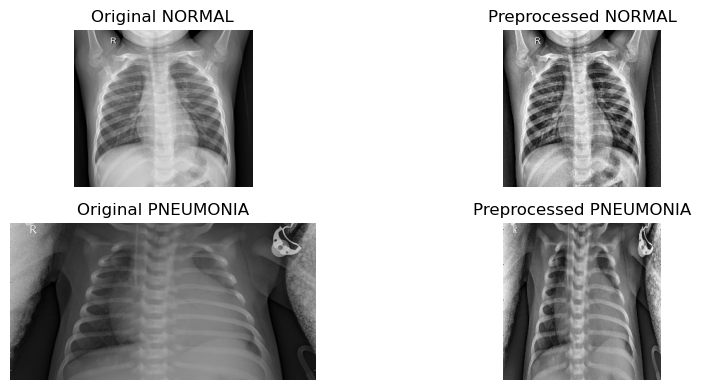

In [3]:
def preprocess_image(img_path, img_size=IMG_SIZE, apply_clahe=False):
    # Load image in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if apply_clahe:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img = clahe.apply(img)
    # Resize image
    img = cv2.resize(img, img_size)
    # Normalize pixel values to [0, 1]
    img = img.astype('float32') / 255.0
    return img

# Visualize preprocessing on sample images
sample_paths = []
for label in classes:
    label_dir = os.path.join(train_dir, label)
    sample_paths.append(os.path.join(label_dir, random.choice(os.listdir(label_dir))))

plt.figure(figsize=(10,4))
for i, path in enumerate(sample_paths):
    img_orig = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img_prep = preprocess_image(path, apply_clahe=True)
    plt.subplot(2,2,2*i+1)
    plt.imshow(img_orig, cmap='gray')
    plt.title(f"Original {classes[i]}")
    plt.axis('off')
    plt.subplot(2,2,2*i+2)
    plt.imshow(img_prep, cmap='gray')
    plt.title(f"Preprocessed {classes[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [4]:
# Data augmentation configuration for training (real-time with Keras)
train_augmentor = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.01,
    zoom_range=[0.9, 1.25],
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='reflect'
)

# For validation and test, only rescale
val_test_augmentor = ImageDataGenerator(rescale=1./255)


In [5]:
# Batch size for model training
BATCH_SIZE = 32

# Training generator
train_generator = train_augmentor.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    classes=classes,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Validation generator
val_generator = val_test_augmentor.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    classes=classes,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Test generator
test_generator = val_test_augmentor.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    classes=classes,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


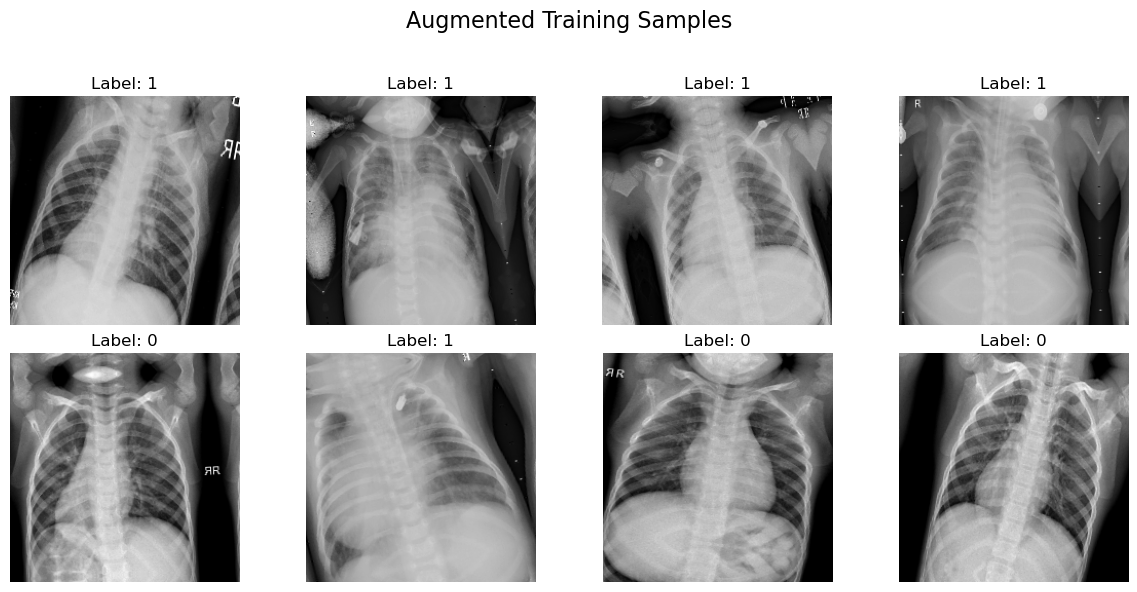

In [6]:
# Visualize some augmented images
x_batch, y_batch = next(train_generator)
plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(x_batch[i].squeeze(), cmap='gray')
    plt.title(f"Label: {int(y_batch[i])}")
    plt.axis('off')
plt.suptitle("Augmented Training Samples", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [7]:
# (Optional) Save preprocessed images to disk for later use (not usually necessary with Keras generators)
# Example for saving a few images:
save_dir = 'processed_samples'
os.makedirs(save_dir, exist_ok=True)
for i in range(10):
    img = (x_batch[i].squeeze() * 255).astype('uint8')
    im = Image.fromarray(img)
    im.save(os.path.join(save_dir, f"sample_{i}_label_{int(y_batch[i])}.png"))
